In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import time, sleep
from fpga_ctrl import FpgaControl

%load_ext autoreload
%autoreload 2

In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Utilities

In [2]:
# Global constants
SAMPLES_PER_LINE = 16384
GAINS_MAX = 32
LINES_MAX = 32
SAMPLE_W = 10
SAMPLE_N = 2 ** SAMPLE_W
SAMPLE_FREQ = 63.75

In [3]:
# Utility functions
def line_to_voltage(line):
    return [((2 * 3.3) / SAMPLE_N) * ((w & (SAMPLE_N - 1)) - SAMPLE_N // 2) for w in line]

def gain_to_voltage(gain):
    return [(1.0 / SAMPLE_N) * g for g in gain]

def gain_expand(gain, length=SAMPLES_PER_LINE):
    return [gain[x // (length // GAINS_MAX)] for x in range(length)]

def gain_staircase(step_width=1, max_value=1024):
    step_val = max_value // GAINS_MAX
    return [step_val - 1 + step_val * step_width * (i // step_width) for i in range(GAINS_MAX)]

def line_complex_sin(offset = 0):
    return [int(512 + 200 * np.sin(2 * np.pi * offset * 1E6 / 127.5E6 + 2 * np.pi * i * 1E6 / 63.75E6) + 
                      100 * np.sin(2 * np.pi * offset * 2E6 / 127.5E6 + 2 * np.pi * i * 2E6 / 63.75E6 ) -
                      80 * np.sin(2 * np.pi * offset * 5E6 / 127.5E6 + 2 * np.pi * i * 5E6 / 63.75E6 ) +
                      20 * np.sin(2 * np.pi * offset * 8E6 / 127.5E6 + 2 * np.pi * i * 8E6 / 63.75E6 )) for i in range(SAMPLES_PER_LINE)]

def plot_line(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = line_to_voltage(line)
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), len(line))
    # prepare time
    t = [1.0 / SAMPLE_FREQ * x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.title(title)
    plt.savefig(title+".png")
    plt.show()

def plot_line_raw(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = [w & (SAMPLE_N - 1) for w in line]
    # prepare gain
    _gain = gain_expand(gain, len(line))
    # prepare time
    t = [x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Sample n')
    ax1.set_ylabel('ADC code', color='b')
    ax2.set_ylabel('DAC code', color='g')
    plt.tight_layout()
    plt.show()

def plot_interleaved_lines(title, line0, line1, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    il_len = len(line0) * 2
    il_freq = SAMPLE_FREQ * 2
    # prepare line 0
    _line0 = line_to_voltage(line0)
    t0 = [1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare line 1
    _line1 = line_to_voltage(line1)
    t1 = [1.0 / il_freq + 1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare interleaved line
    il_line = [_line1[i//2] if i % 2 else _line0[i//2] for i in range(il_len)]
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), il_len)
    # prepare time
    t = [1.0 / il_freq * x for x in range(il_len)]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, il_line, 'b-')
    if dots:
        ax1.plot(t0, _line0, 'ro')
        ax1.plot(t1, _line1, 'yo')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.show()

# Acquisition demonstration

## Connect FPGA

In [4]:
# init FTDI device
fpga = FpgaControl('ftdi://ftdi:2232:/', spi_freq=8E6)
# reload configuration (optional step - just to fill BRAM (DACGAIN registers) with initial values)
fpga.reload()
# reset fpga
fpga.reset()

## Do acquisition

### Checking all is well plugged

In [5]:
fpga.csr.ponw = 16
fpga.csr.interw = 16
fpga.csr.poffw = 4096

In [42]:
gain = [int(100 + ((1000-100)*x*x*x/32/32/32)) for x in range(32)]

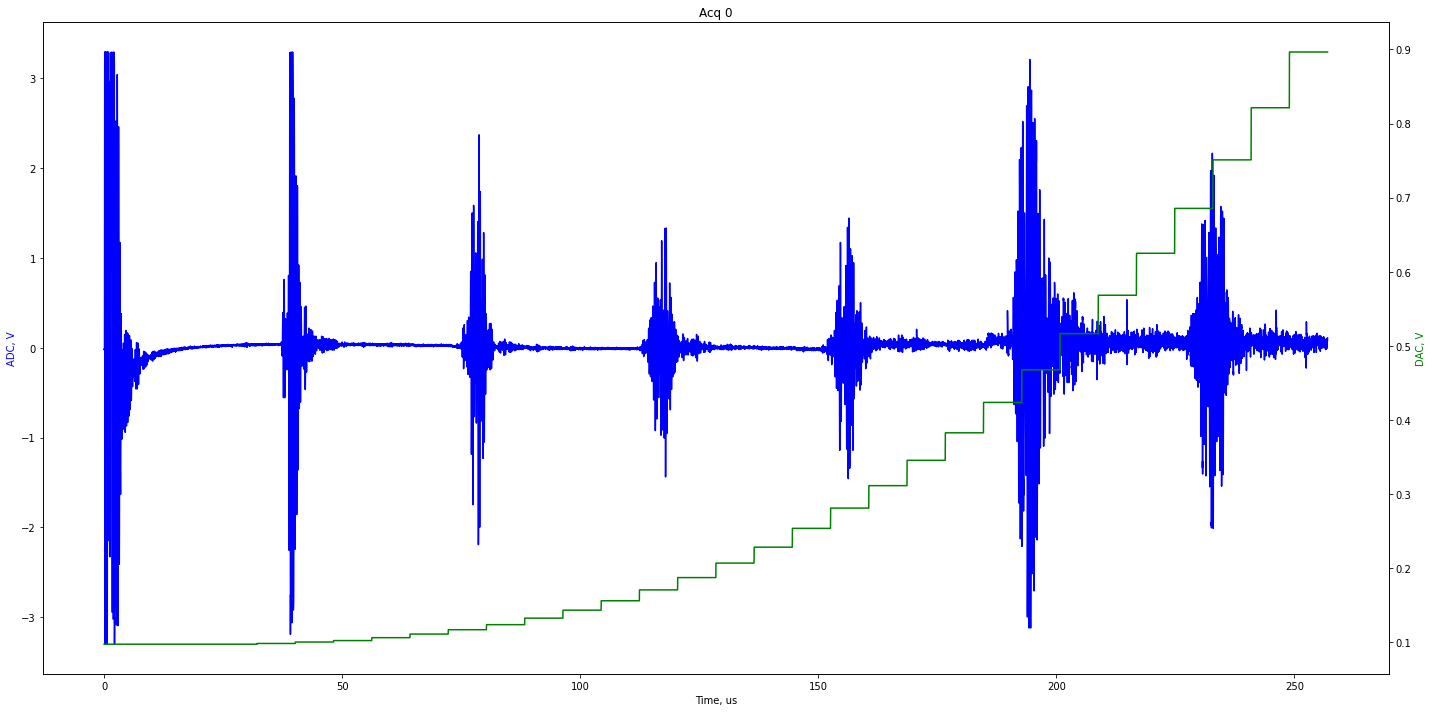

In [44]:
acq_res = fpga.do_acquisition(acq_lines=32, gain=gain, double_rate=True)
plot_line("Acq 0", acq_res[0], gain)

In [46]:
data = {}
data["gain"]=gain
data["double_rate"]="True"
for i in range(32):
    data[i]=acq_res[i]

In [47]:
import json

with open('32_lines.json', 'w') as fp:
    json.dump(data, fp)

### Trying to find the optimal  pulse pattern for the piezo

In [64]:
MaxLength=350

In [65]:
data ={}
for i in range(MaxLength):
    gain = gain_staircase(2, 650)

    ValWidth = i
    fpga.csr.ponw = ValWidth
    fpga.csr.interw = ValWidth
    fpga.csr.poffw = 5000-2*ValWidth

    acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=False)

    print(acq_res[0] == acq_res[1])
    data[ValWidth] = acq_res[0][4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [66]:
import json

with open('all_width.json', 'w') as fp:
    json.dump(data, fp)

### Starting anew

In [99]:
with open('all_width.json', 'r') as fp:
    data = json.load(fp)

In [100]:
data.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

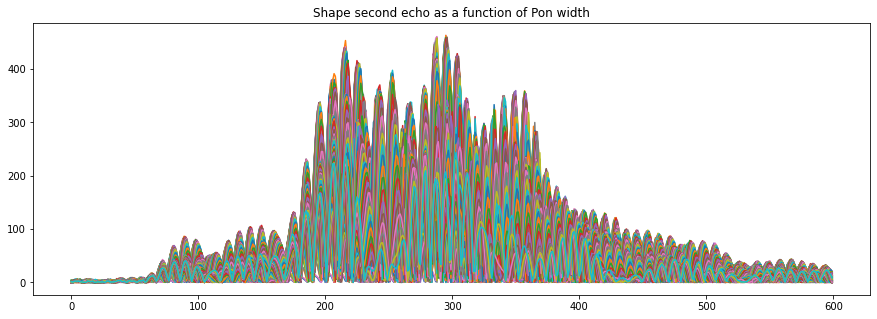

In [105]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in range(MaxLength):
    k = str(k)
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.title("Shape second echo as a function of Pon width")
plt.savefig("2nd_echo.png")
plt.show()

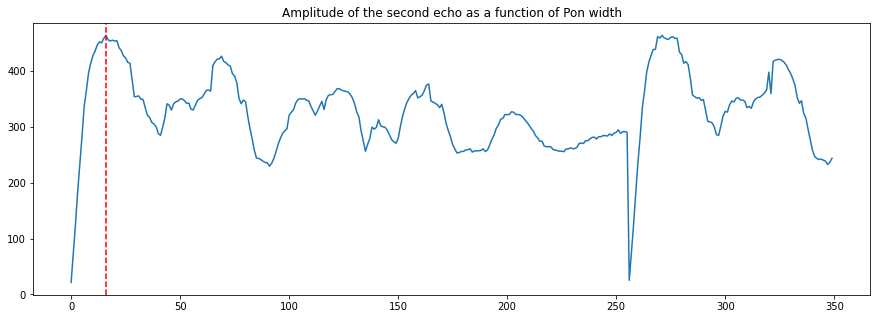

In [104]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:50])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Amplitude of the second echo as a function of Pon width")
plt.savefig("amplitude.png")
plt.show()


# Finding now the best Pinterdelay parameter

In [108]:
data ={}
RANGE = 30
MIDRANGE = int(RANGE/2)

for i in range(RANGE):
    gain = gain_staircase(2, 650)

    ValWidth = i
    fpga.csr.ponw = 16+(i-MIDRANGE)
    fpga.csr.interw = 16-(i-MIDRANGE)
    fpga.csr.poffw = 5000-2*ValWidth

    acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=False)

    print(i,acq_res[0] == acq_res[1])
    data[16+(i-MIDRANGE)] = acq_res[0][4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)
KEYS = [x for x in data.keys()]

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False


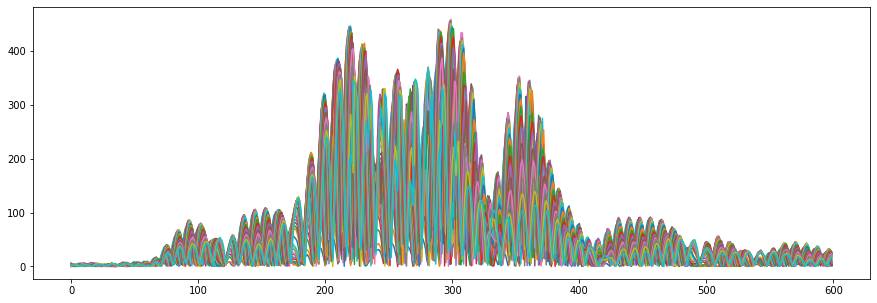

In [109]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in KEYS: 
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.show()

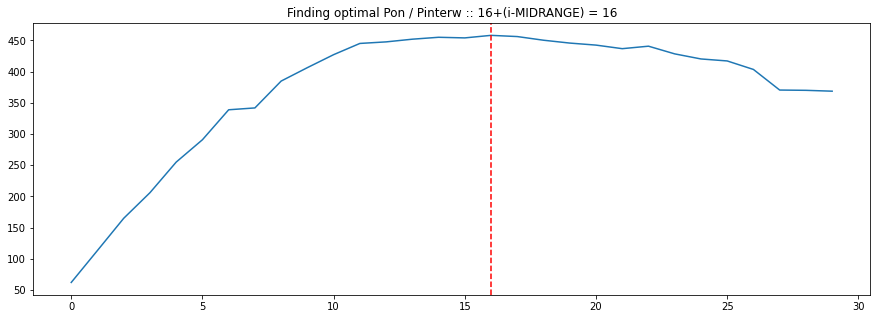

In [110]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:50])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Finding optimal Pon / Pinterw :: 16+(i-MIDRANGE) = "+str(m))
plt.show()

#### Second parameter now

In [21]:
data ={}
RANGE = 100

for i in range(RANGE):

    ValWidth = i
    fpga.csr.ponw = 16
    fpga.csr.interw = i
    fpga.csr.poffw = 5000-16-i

    acq_res = fpga.do_acquisition(acq_lines=4, gain=gain, double_rate=False)

    print(i,acq_res[0] == acq_res[1])
    data[i] = ((np.array(acq_res[0])+np.array(acq_res[1])+np.array(acq_res[2])+np.array(acq_res[3]))/4)[4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)
KEYS = [x for x in data.keys()]

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False


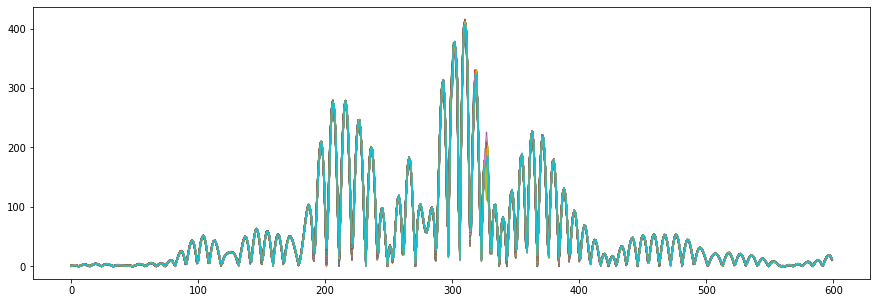

In [22]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in KEYS: 
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.show()

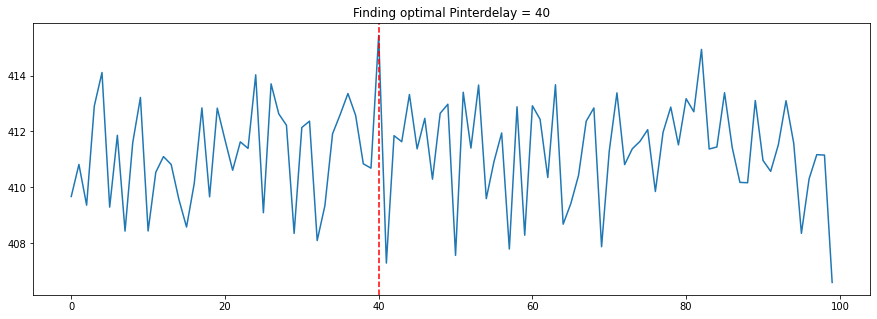

In [25]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:90])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Finding optimal Pinterdelay = "+str(m))
plt.savefig("pint.png")
plt.show()

## Now for PDamp

In [31]:
data ={}
RANGE = 50

for i in range(RANGE):

    fpga.csr.ponw = 16
    fpga.csr.interw = 16
    fpga.csr.poffw = 100*i

    acq_res = fpga.do_acquisition(acq_lines=4, gain=gain, double_rate=False)

    print(100*i,acq_res[0] == acq_res[1])
    data[100*i] = ((np.array(acq_res[0])+np.array(acq_res[1])+np.array(acq_res[2])+np.array(acq_res[3]))/4)[4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)
KEYS = [x for x in data.keys()]

0 False
100 False
200 False
300 False
400 False
500 False
600 False
700 False
800 False
900 False
1000 False
1100 False
1200 False
1300 False
1400 False
1500 False
1600 False
1700 False
1800 False
1900 False
2000 False
2100 False
2200 False
2300 False
2400 False
2500 False
2600 False
2700 False
2800 False
2900 False
3000 False
3100 False
3200 False
3300 False
3400 False
3500 False
3600 False
3700 False
3800 False
3900 False
4000 False
4100 False
4200 False
4300 False
4400 False
4500 False
4600 False
4700 False
4800 False
4900 False


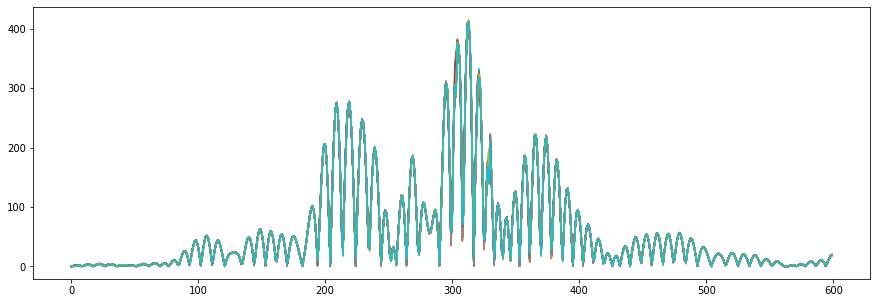

In [32]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in KEYS: 
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.show()

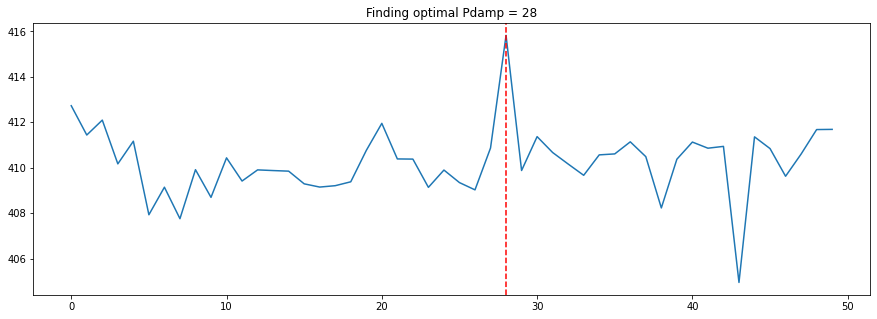

In [33]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:90])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Finding optimal Pdamp = "+str(m))
plt.savefig("pdamp.png")
plt.show()

## Disconnect FPGA

In [24]:
# reset fpga again (optional)
fpga.reset()
# close FTDI interface
fpga.disconnect()